In [51]:
import math
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [7]:
#Função Sphere
def sphere(vetor, limite_inferior=-100, limite_superior=100):
  resultado = 0
  
  for i in vetor:
    resultado += i**2
  
  return resultado

#Função rastrigin
def rastrigin(vetor, limite_inferior=-30, limite_superior=30):
  resultado = 0
  
  for i in vetor:
    x = 2*math.pi*i
    resultado += 10 + ((i**2) - 10 * math.cos(x))
    

  return resultado 

#Função rosenbrock
def rosenbrock(vetor, limite_inferior=-5.12, limite_superior=5.12):
  resultado = 0
  
  for i in range(0,(len(vetor)-1)):
    resultado += 100*(vetor[i+1] - vetor[i]**2)**2 + (vetor[i] - 1)**2
    
  return resultado

In [8]:
class Selecao(Enum):
    PROPORCIONAL = 0
    TORNEIO = 1


In [49]:
# Algoritmo genético
class AlgoritmoGenetico:
    def __init__(self, funcao_fitness, limite_inferior, limite_superior, tipo_selecao, tipo_cruzamento, dimensao=30, tamanho_populacao=30, geracoes=20, taxa_mutacao=0.01, taxa_cruzamento=0.7):
        self.funcao_fitness = funcao_fitness
        self.limite_inferior = limite_inferior
        self.limite_superior = limite_superior
        self.tipo_selecao = tipo_selecao
        self.tipo_cruzamento = tipo_cruzamento
        self.quantidade_genes = dimensao
        self.tamanho_populacao = tamanho_populacao
        self.geracoes = geracoes
        self.taxa_mutacao = taxa_mutacao
        self.taxa_cruzamento = taxa_cruzamento
        self.historico_fitness = []                             
                                                                     # A taxa de cruzamento geralmente fica entre 0.6 e 0.9
                                                                     # A taxa de cruzamento olha pro cromossomo, enquanto o de mutação olha pro gene
                                                                     # Eu posso ter o mesmo cromossomo selecionado mais de uma vez
                                                                     # Tenho que minimizar o valor
                                                                     # O melhor ficar no torneio: nesse caso, o mínimo?
                                                                     # E se o número de cromossomos for ímpar? Retorna pro primeiro, ou seja, o último e o primeiro.
                                                                     # Gerando, assim, um único filho. Ou podemos duplicá-lo e passá-lo pela mutação.
                                                                     # Tem que ter os parâmetros para indicar se o cruzamento é de 1 ou de 2 pontos, se a seleção é de torneio ou 
                                                                     # de proporcionalidade.

                                                                     # DEVO LEVAR EM CONSIDERAÇÃO OS ELEMENTOS ABAIXO 

                                                                     # Testar tanto com os números inteiros quanto com os reais: Sphere e Rastrigin. Rosenbrock é só com reais
                                                                     # O retorno é para ser o melhor cromossomo da última geração
                                                                     # É interessante guardar qual foi o melhor cromossomo de cada geração. Podemos guardá-los em uma lista 
                                                                     # Esse último ponto é interessante para identificar se o algoritmo está convergindo ou não.
                                                                     # Podemos criar um gráfico ou fazer um print. O gráfico seria Y(Fitness) e X(Gerações) - MATPLOTLIB
                                                                     
        self.populacao = np.random.uniform(low=self.limite_inferior, high=self.limite_superior, size=(tamanho_populacao, self.quantidade_genes))
    
    def evoluir(self):
        for geracao in range(self.geracoes):
            fitness = self.avaliar()
            proxima_populacao = self.selecionar(fitness, tipo=self.tipo_selecao)
            self.cruzar(proxima_populacao, tipo=self.tipo_cruzamento)
            self.mutar(proxima_populacao)
            self.populacao = proxima_populacao
            self.historico_fitness.append(np.min(fitness))
            melhor_solucao = self.populacao[np.argmin(fitness)]
            if geracao == (self.geracoes - 1):
                print(f"Geração {geracao+1} | Melhor solução: {melhor_solucao} | Fitness: {np.min(fitness)} | Histórico Fitness: {self.historico_fitness}")
        return melhor_solucao

    def avaliar(self):
        return np.array([self.funcao_fitness(cromossomo) for cromossomo in self.populacao])
    
    def somar_total_fitness(self):
        return np.sum(self.avaliar())
    
    def selecionar(self, fitness, tipo):
        selecionado = []
        if tipo == Selecao.TORNEIO:
            for _ in range(self.tamanho_populacao):
                index_cromossomo1, index_cromossomo2 = np.random.choice(np.arange(self.tamanho_populacao), size=2)
                selecionado.append(self.populacao[index_cromossomo1] if fitness[index_cromossomo1] < fitness[index_cromossomo2] else self.populacao[index_cromossomo2])
        elif tipo == Selecao.PROPORCIONAL:
            total_fitness_invertido = np.sum([1 / fitness[i] for i in range(self.tamanho_populacao)])
            proporcoes_fitness = []
            for i in range(self.tamanho_populacao):
                proporcoes_fitness.append(1 / fitness[i] / total_fitness_invertido)
            for i in range(self.tamanho_populacao):
                probabilidade_random = np.random.rand()
                probabilidade_acumulativa = 0
                for cromossomo, proporcao in zip(self.populacao, proporcoes_fitness):
                    probabilidade_acumulativa += proporcao
                    if probabilidade_random <= probabilidade_acumulativa:
                        selecionado.append(cromossomo)
                        break
        return np.array(selecionado)

    def cruzar(self, populacao, tipo): 
        for i in range(0, self.tamanho_populacao - 1):
            if np.random.rand() <= self.taxa_cruzamento:
                if tipo == 1:
                    ponto_cruzamento = np.random.randint(1, self.quantidade_genes - 1)
                    if self.tamanho_populacao % 2 == 1 and i == self.tamanho_populacao - 1:
                        populacao[i+1, ponto_cruzamento:] = populacao[0, ponto_cruzamento:]
                    else:
                        populacao[i, ponto_cruzamento:], populacao[i+1, ponto_cruzamento:] = \
                            populacao[i+1, ponto_cruzamento:], populacao[i, ponto_cruzamento:]
                elif tipo == 2:
                    ponto1 = np.random.randint(1, self.quantidade_genes - 2)
                    ponto2 = np.random.randint(ponto1 + 1, self.quantidade_genes - 1)
                    if self.tamanho_populacao % 2 == 1 and i == self.tamanho_populacao - 1:
                        populacao[i+1, ponto1:ponto2] = populacao[0, ponto1:ponto2]
                    else:
                        populacao[i, ponto1:ponto2], populacao[i+1, ponto1:ponto2] = \
                            populacao[i+1, ponto1:ponto2], populacao[i, ponto1:ponto2]

    def mutar(self, populacao):
        for cromossomo in populacao:
            if np.random.rand() <= self.taxa_mutacao:
                ponto_mutacao = np.random.randint(self.quantidade_genes)
                cromossomo[ponto_mutacao] = np.random.uniform(low=self.limite_inferior, 
                                                               high=self.limite_superior)
                
    def plotar_grafico_convergencia(self): 
        valores_x = list(range(self.geracoes))
        plt.figure(figsize=(10, 6))
        plt.plot(valores_x, self.historico_fitness, marker='o', linestyle='-', color='b', label='Fitness')
        plt.xlabel('Geracao')
        plt.ylabel('Melhor Fitness')
        plt.title('Melhor Fitness vs. Geracao')
        plt.grid(True)
        plt.legend()
        plt.show()


Geração 20 | Melhor solução: [-2.7566562   2.41813378  0.56511242  3.68090349  3.82293519  4.81040303
 -2.60223157 -1.07318785 -3.67176554  0.28278627 -2.41640112 -4.56302693
  4.49912627 -0.38826172 -3.34931482  0.36658737  2.68355159  2.93468715
 -3.01752711  0.84099888  2.62680837  2.37829963  1.65399004  2.11307198
  0.45502694 -0.84612718 -1.33247655 -4.8605341   0.80955816  3.63125416] | Fitness: 217306.20135886173 | Histórico Fitness: [221301.56107368314, 227172.26036168748, 217983.23308868875, 217983.23308868875, 210339.73244356932, 307941.4943341913, 287842.43226693955, 278106.1995854563, 285056.9694717105, 284147.7518837105, 276351.2452835306, 238937.0308580301, 229865.86464106428, 229865.86464106428, 262053.44683751574, 228857.88723203106, 253961.91192853908, 250501.7609643464, 217306.20135886173, 217306.20135886173]


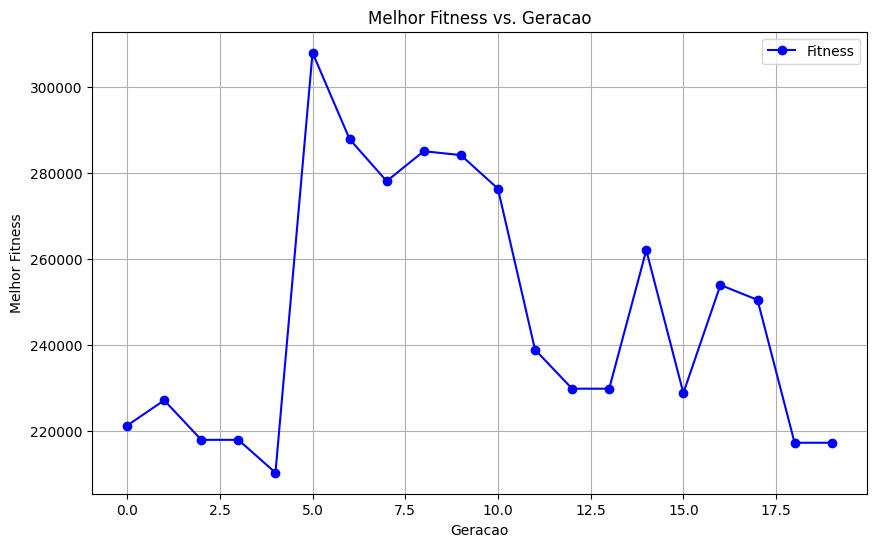

In [50]:
ag1 = AlgoritmoGenetico(rosenbrock, limite_inferior=-5.12, limite_superior=5.12, tipo_cruzamento=2, tipo_selecao=Selecao.PROPORCIONAL)
ag1.evoluir()
ag1.plotar_grafico_convergencia()